# Supplementary figure coupling coefficient for MICrONS and BBP dataset

In [1]:
# General 
import numpy as np
import pandas as pd
from scipy import stats
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Connectomes and network analysis
import conntility
# Specific to this project
import sys 
sys.path.append('../../../library')
from structural_basic import load_connectome
from utils_microns_bbp import *
from plotting_utils import *

In [2]:
configs={} #Paths to activity and structural data 

# Paths to data and specs 
configs["BBP"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline/working_dir/reliability_basic.npz",
    "fname_CC": "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/working_dir/coupling_coefficients.h5",
    "norm_types": ["global", "per_cell"],
    "fname_rates":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/toposample_input/raw_spikes_exc.npy",
    "format_rates":"toposample",
    "bin_size":"2p0", 
    "fname_effciency":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_signals.pkl",
    "properties":["CC", "CC_norm_cell", "reliability", "efficiency"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

configs["MICrONS"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "fname_CC": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "norm_types": ["global", "per_cell"],
    "fname_rates": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "format_rates":None,
    "bin_size":None, 
    "save_dir":"../../data", 
    "average_type":["per_layer", "full"], 
    "properties":["CC", "CC_norm_cell", "reliability"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

connectomes, simp_layer_raw, simp_full_raw ={}, {}, {}

#Load precomputed data 
conns=["MICrONS", "BBP"]
for conn in conns:
    cfg=configs[conn]
    stypes=cfg["stypes"]
    base_graph=cfg["base_graph"]
    # Get connectome and porperties per node 
    connectome=load_connectome(cfg["connectome_dir"], conn)
    connectome = add_layers(conn, connectome)
    connectome = add_reliability(connectome, conn, cfg["fname_reliability"])
    connectome = add_firing_rates(connectome,conn, cfg["fname_rates"], cfg["format_rates"]) 
    for norm_type in cfg["norm_types"]:
        connectome = add_cc(connectome, conn, cfg["fname_CC"], norm_type, bin_size=cfg["bin_size"])
    connectomes[conn]=connectome
    # Adding properties of neighbohoords 
    nbd_props=pd.read_pickle(f'/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/props_{conn}_original.pkl')
    for col in nbd_props.columns:
        connectomes[conn].add_vertex_property(new_label=col,new_values=nbd_props[col].to_numpy())
    
# Load dimension of activity (BBP only)
conn="BBP"
connectomes[conn]=add_efficiency(conn, connectomes[conn], configs[conn]["fname_effciency"])

In [3]:
# Get top and bottom complexity neighborhoods with active centers
complexity_metric="wasserstein_deg_total"
activity_property="reliability" # To subselect only active neurons
#for conn in conns:
for conn in conns:
    df=connectomes[conn].vertices

    tresh=0.05 # Fix percentile threhsold
    tresh=100/(~np.isnan(df[activity_property])).sum() # Fixed sample size 100 centers

    # Restrict to centers with registered activity
    x=(df[~np.isnan(df[activity_property])])["wasserstein_deg_total"] 
    df['nbd_complexity']=np.nan
    # Sparse ones
    df['nbd_complexity'][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'
    # Dense ones
    df['nbd_complexity'][df[complexity_metric]>np.quantile(x, 1-tresh)]='high complexity'
    connectomes[conn].add_vertex_property(new_label="nbd_complexity",new_values=df["nbd_complexity"].to_numpy())

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2043781/ipykernel_229904/1980634752.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nbd_complexity'][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2043781/ipykernel_229904/1980634752.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nbd_complexity'][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'


# Plotting basics 

In [4]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
#conversion=1.5

marker_size=2
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
colors={
    'high complexity': 'tab:purple', 
    'low complexity': 'tab:cyan', 
    2:matplotlib.colormaps["Set3"](0),
    3:matplotlib.colormaps["Set3"](2),
    4:matplotlib.colormaps["Set3"](5),
    5:matplotlib.colormaps["Set3"](4),
    6:matplotlib.colormaps["Set3"](3),
    "all":"C0",
    "sink": "C1",
    "source":"C2"
}
markers={"all":"o",
       "sink": ">",
       "source":"<"}
alpha=0.25

# Analysis per node 

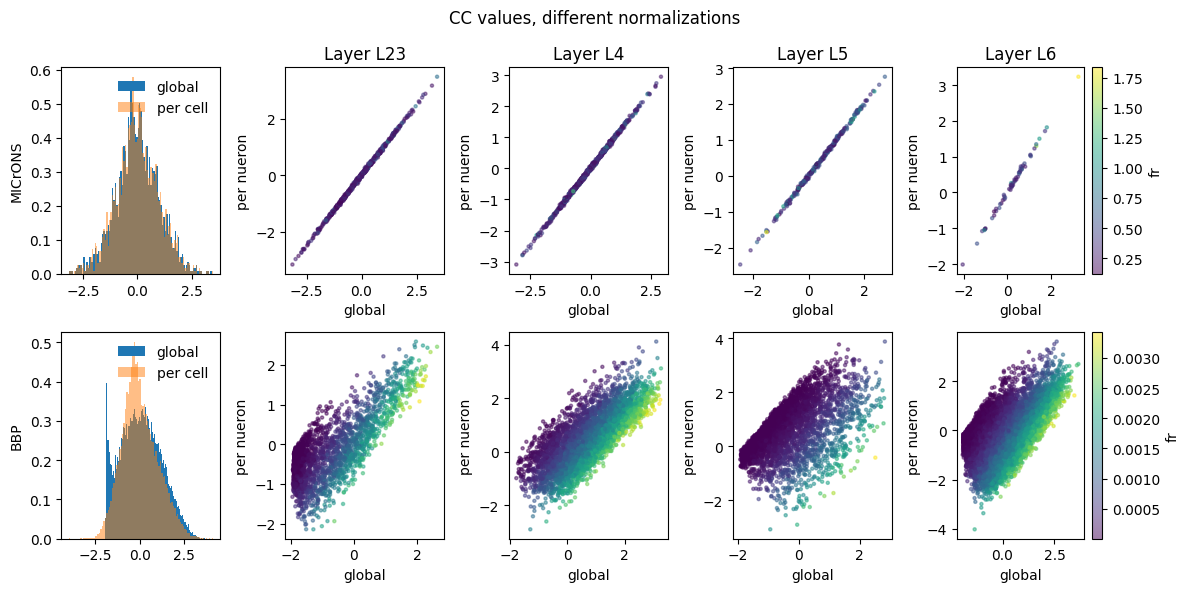

In [5]:
layers=["L23", "L4", "L5", "L6"]
fig, axs = plt.subplots(2,5, figsize=(12,6))
for i, conn in enumerate(conns):
    df=connectomes[conn].vertices
    axs[i, 0].hist(df["CC"],density=True, label="global", bins=100)
    axs[i, 0].hist(df["CC_norm_cell"], alpha=0.5,density=True, label="per cell", bins=100)
    axs[i,0].legend(frameon=False)
    axs[i,0].set_ylabel(conn)
    for j, layer in enumerate(layers, start=1):
        df=connectomes[conn].vertices.query(f"layer_group=='{layer}'")
        plot=axs[i, j].scatter(df["CC"],df["CC_norm_cell"], s=5, alpha=0.5,c=df["rates"])
        axs[i,j].set_xlabel("global")
        axs[i,j].set_ylabel("per nueron")
        axs[0, j].set_title(f"Layer {layer}")
    plt.colorbar(plot, label="fr")
plt.suptitle("CC values, different normalizations")
plt.tight_layout()      

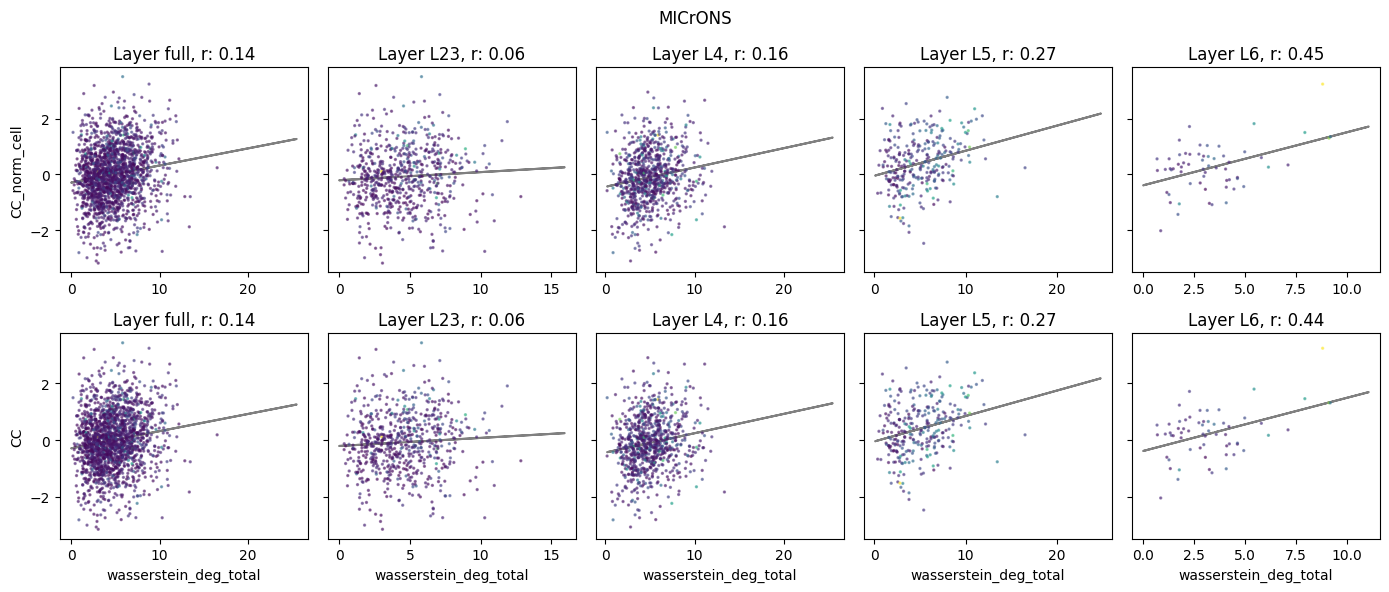

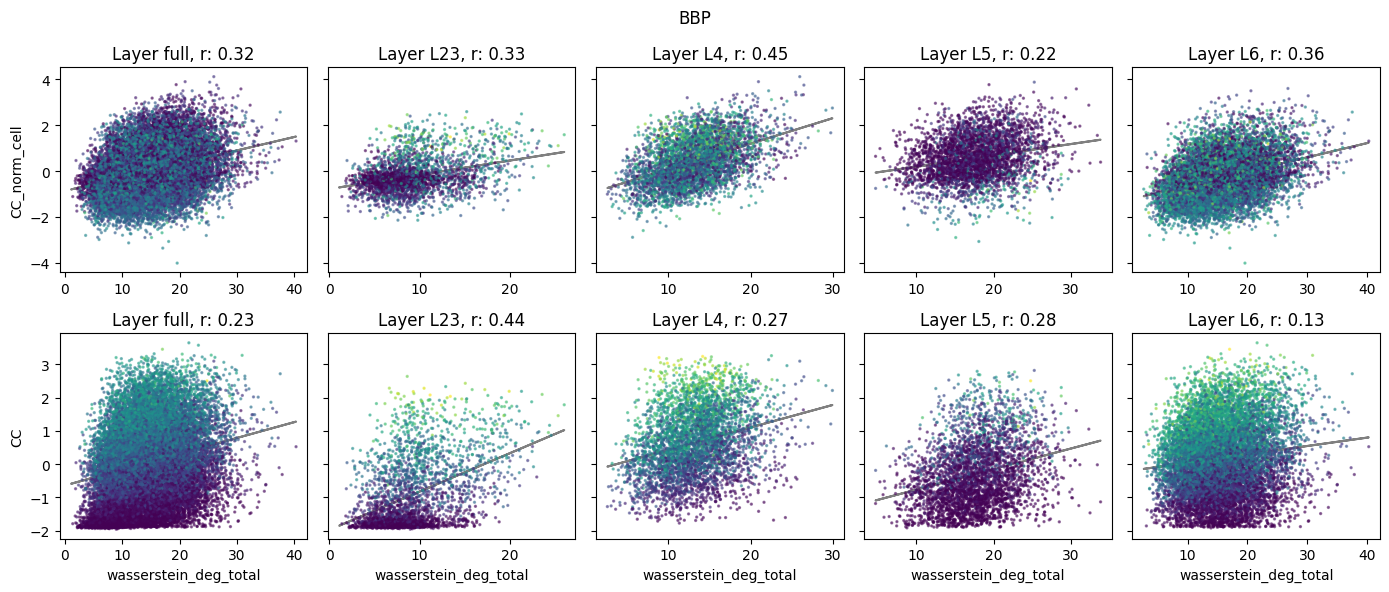

In [6]:
for conn in conns:
    complexity_metric="wasserstein_deg_total"
    fig, axs = plt.subplots(2,5, figsize=(14,6), sharey="row")
    
    for j, layer in enumerate(["full"]+layers):
        if layer =="full":
            df=connectomes[conn].vertices
        else:
            df=connectomes[conn].vertices.query(f"layer_group=='{layer}'")
        x=df[complexity_metric].astype("float")
        color=df["rates"]
        for i, y_prop in enumerate(["CC_norm_cell", "CC"]):
            if y_prop=="efficiency":
                y=(df["actitivy_dimension"]/df["active_ts"]).astype("float")
            else: 
                y=df[y_prop].astype("float")
            axs[i,j], h, l=scatter_and_regress(axs[i,j],x, y, color, marker='o', marker_size=marker_size, label=None, color_regress="gray")
            axs[i,j].set_title(f"Layer {layer}, r: {l[0]}")
            axs[i,0].set_ylabel(y_prop)
            axs[-1,j].set_xlabel(complexity_metric)
    plt.suptitle(conn)
    plt.tight_layout()


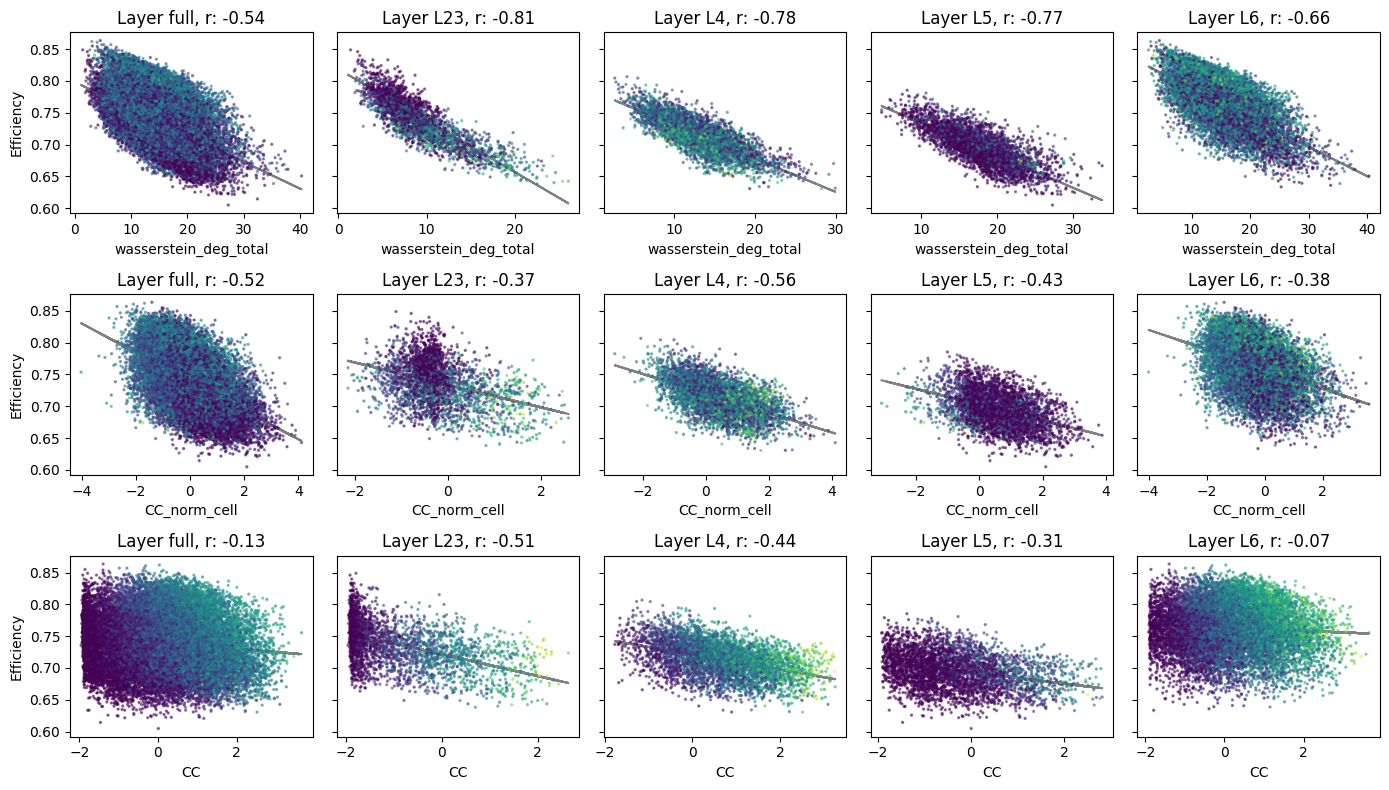

In [7]:
conn="BBP"
complexity_metric="wasserstein_deg_total"
fig, axs = plt.subplots(3,5, figsize=(14,8), sharey="row")

for j, layer in enumerate(["full"]+layers):
    if layer =="full":
        df=connectomes[conn].vertices
    else:
        df=connectomes[conn].vertices.query(f"layer_group=='{layer}'")
    y=(df["actitivy_dimension"]/df["active_ts"]).astype("float")
    color=df["rates"]
    for i, x_prop in enumerate([complexity_metric, "CC_norm_cell", "CC"]):
        x=df[x_prop].astype("float")
        axs[i,j], h, l=scatter_and_regress(axs[i,j],x, y, color, marker='o', marker_size=marker_size, label=None, color_regress="gray")
        axs[i,j].set_title(f"Layer {layer}, r: {l[0]}")
        axs[i,j].set_xlabel(x_prop)
        axs[i,0].set_ylabel("Efficiency")

plt.tight_layout()


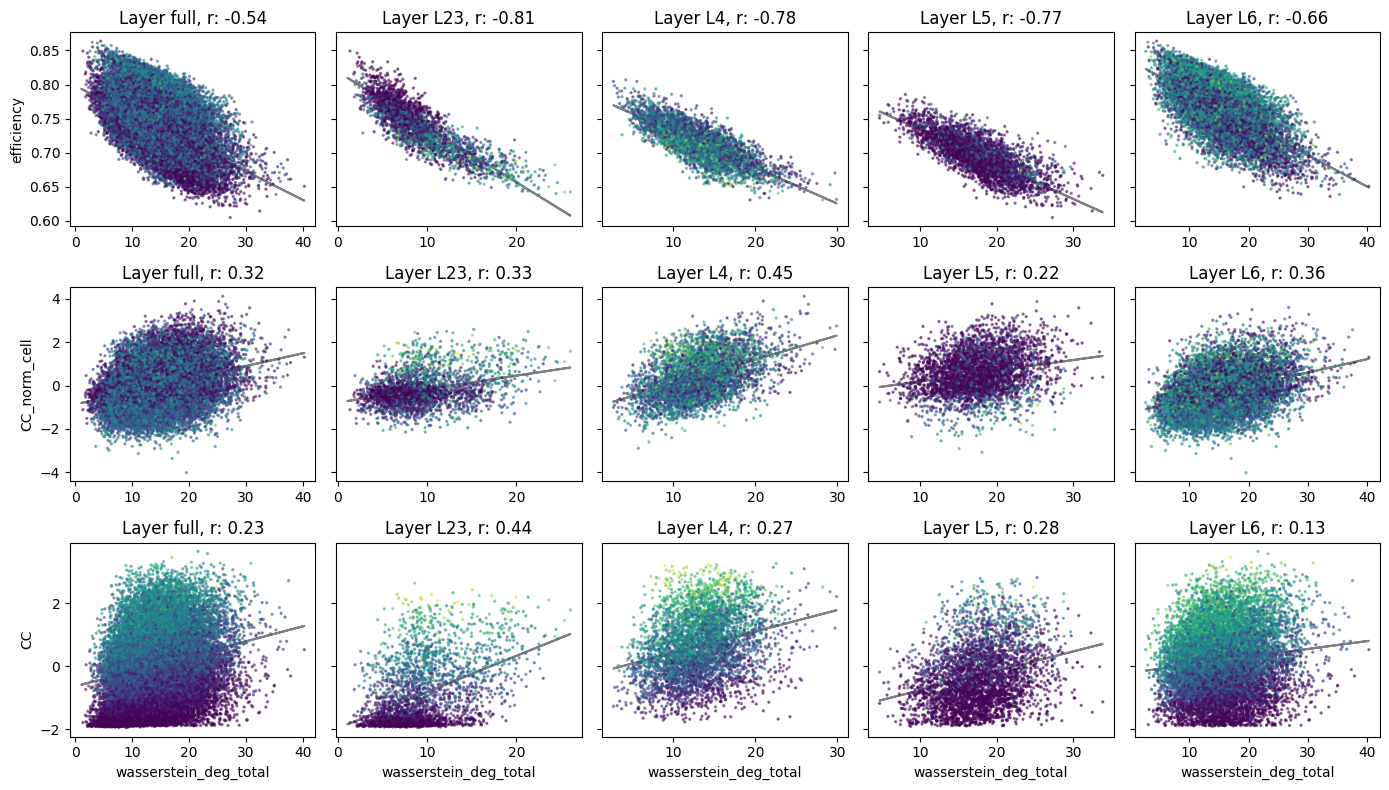

In [8]:
conn="BBP"
complexity_metric="wasserstein_deg_total"
fig, axs = plt.subplots(3,5, figsize=(14,8), sharey="row")

for j, layer in enumerate(["full"]+layers):
    if layer =="full":
        df=connectomes[conn].vertices
    else:
        df=connectomes[conn].vertices.query(f"layer_group=='{layer}'")
    x=df[complexity_metric].astype("float")
    color=df["rates"]
    for i, y_prop in enumerate(["efficiency", "CC_norm_cell", "CC"]):
        if y_prop=="efficiency":
            y=(df["actitivy_dimension"]/df["active_ts"]).astype("float")
        else: 
            y=df[y_prop].astype("float")
        axs[i,j], h, l=scatter_and_regress(axs[i,j],x, y, color, marker='o', marker_size=marker_size, label=None, color_regress="gray")
        axs[i,j].set_title(f"Layer {layer}, r: {l[0]}")
        axs[i,0].set_ylabel(y_prop)
        axs[-1,j].set_xlabel(complexity_metric)

plt.tight_layout()


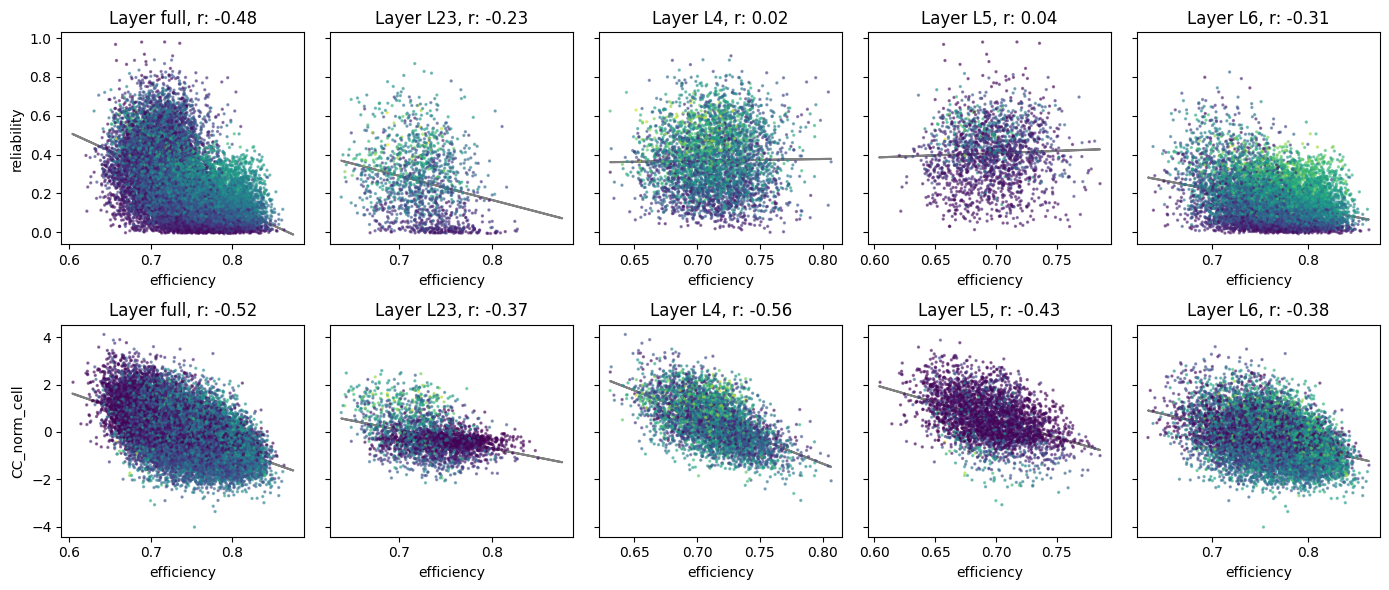

In [9]:
conn="BBP"
complexity_metric="wasserstein_deg_total"
fig, axs = plt.subplots(2,5, figsize=(14,6), sharey="row")

for j, layer in enumerate(["full"]+layers):
    if layer =="full":
        df=connectomes[conn].vertices
    else:
        df=connectomes[conn].vertices.query(f"layer_group=='{layer}'")
    x=df["efficiency"].astype("float")
    color=df["rates"]
    for i, y_prop in enumerate(["reliability", "CC_norm_cell"]):
        if y_prop=="efficiency":
            y=(df["actitivy_dimension"]/df["active_ts"]).astype("float")
        else: 
            y=df[y_prop].astype("float")
        axs[i,j], h, l=scatter_and_regress(axs[i,j],x, y, color, marker='o', marker_size=marker_size, label=None, color_regress="gray")
        axs[i,j].set_title(f"Layer {layer}, r: {l[0]}")
        axs[i,0].set_ylabel(y_prop)
        axs[i,j].set_xlabel("efficiency")

plt.tight_layout()

CC MICrONS


For connectome MICrONS
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=9.568692537313495, pvalue=0.001979236922723042)
CC_norm_cell MICrONS


For connectome MICrONS
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=9.888770149253673, pvalue=0.0016629047228115153)
CC BBP


For connectome BBP
Sample size 193, 130
Kruskal-Wallis H-test KruskalResult(statistic=128.71921752189868, pvalue=7.812402393587224e-30)
CC_norm_cell BBP


For connectome BBP
Sample size 193, 130
Kruskal-Wallis H-test KruskalResult(statistic=177.38429653248295, pvalue=1.8053323067132927e-40)
efficiency BBP


For connectome BBP
Sample size 388, 135
Kruskal-Wallis H-test KruskalResult(statistic=299.43554277822517, pvalue=4.372682725163644e-67)


/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2043781/ipykernel_229904/3675138437.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2043781/ipykernel_229904/3675138437.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2043781/ipykernel_229904/3675138437.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

'for ax in axs[:, :-1].flatten():\n    ax.axis("off")'

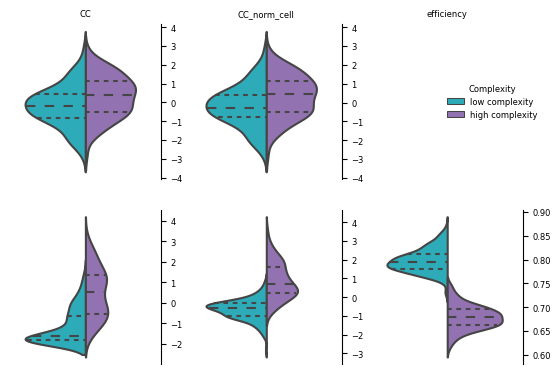

In [10]:
# Plotting extremals
width=21*0.8/conversion

rows=2; cols=3
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows/cols), sharex=False, sharey=False)

# Plotting violins of extremals
for i, conn in enumerate(conns):
    for j, property in enumerate(["CC", "CC_norm_cell", "efficiency"]):

        if property !="efficiency":
            df=connectomes[conn].vertices
        if (property =="efficiency" and conn=="BBP"):
            df=connectomes["BBP"].vertices
        
        if (property=="efficiency" and conn=="MICrONS"):
            axs[i,j].axis("off")
        else:
            print(property, conn)
           
            data=df[np.logical_or(df["nbd_complexity"]=="high complexity", 
                                               df["nbd_complexity"]=="low complexity")]
            data["dummy"]=1
            # Test difference of means 
            x=data.query("nbd_complexity== 'low complexity'")[property].to_numpy()
            y=data.query("nbd_complexity== 'high complexity'")[property].to_numpy()
            x=x[~np.isnan(x)]; y=y[~np.isnan(y)]
            print(f"\n\nFor connectome {conn}")
            print(f"Sample size {x.shape[0]}, {y.shape[0]}")
            print(f"Kruskal-Wallis H-test {stats.kruskal(x, y)}")
            
            #Plot violins 
            axs[i,j]=plot_violin(axs[i,j], y=property, data=data)
            axs[i,j].get_legend().remove()
            axs[i,j].yaxis.tick_right()
            axs[i,j].tick_params(axis='both', labelsize=ticksize)
            #axs[i,j].set_ylabel("Coupling coefficient",fontsize=labelsize) 
            axs[i,j].set_ylabel("",fontsize=labelsize) 
            axs[i,j].yaxis.set_label_position("right")
            axs[0,j].set_title(property,fontsize=labelsize)

# Legends 
axs[0,1].legend(frameon=False,ncol=1, loc="center", bbox_to_anchor=(2,0.5),fontsize=labelsize,
                title="Complexity", title_fontsize=labelsize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

'''for ax in axs[:, :-1].flatten():
    ax.axis("off")'''
#fig.savefig(f"figs/reliab_extremals_both_connectomes.pdf", transparent=True, bbox_inches="tight")


# Simplicial structure 

In [11]:
# Get simplicial structure  
for conn in conns: 
    cfg=configs[conn]
    simp_layer_raw[conn], simp_full_raw[conn] ={}, {}
    for property in cfg["properties"]:
        fname=f"{cfg['simplicial_dir']}/node_stats_per_layer_{property}_{conn}_{base_graph}.pkl"
        simp_layer_raw[conn][property]=pd.read_pickle(fname)
        fname=f"{cfg['simplicial_dir']}/node_stats_full_{property}_{conn}_{base_graph}.pkl"
        simp_full_raw[conn][property]=pd.read_pickle(fname)

# Reformat for plotting 
simplicial_full=agg_along_dims_single(simp_full_raw)
simplicial_layers=agg_along_dims_layers(simp_layer_raw)


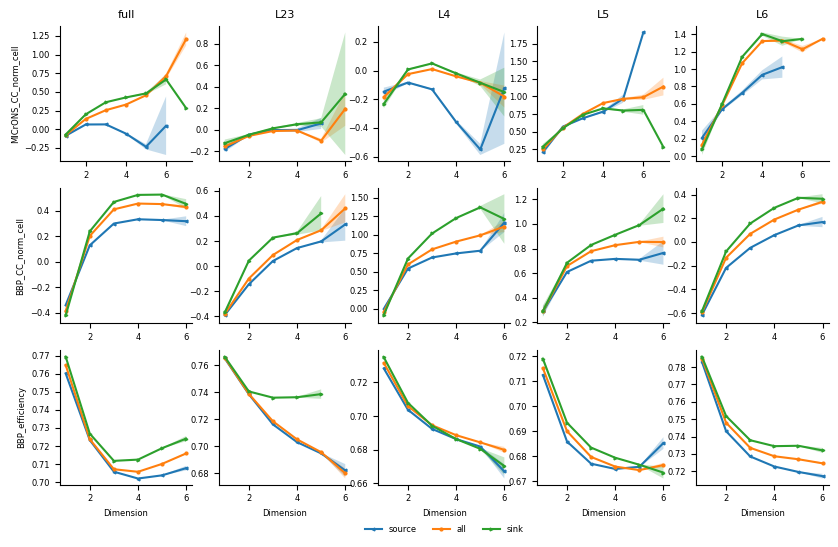

In [12]:
# Plotting figure prototype 
width=21*0.8/conversion


rows=3; cols=5
fig, axs =plt.subplots(rows,cols,figsize=(width*1.5, width*rows*1.5/cols), sharex=False, sharey=False)
# Coupling across simplices 
stype="maximal" # Consider maximal simplices
for j, l in enumerate(["full"]+layers):
#for j, l in enumerate(["L23"]):
    axs[0,j].set_title(f"{l}", fontsize=titlesize)
    for pos in ["source", "all", "sink"]: 
        for i, conn in enumerate(conns+["BBP"]):
            if i<2:
                property="CC_norm_cell"
            else:
                property="efficiency"; conn="BBP"
            if l =="full":
                df=simplicial_full[conn][property][stype][pos]
            else: 
                df=simplicial_layers[l][conn][property][stype][pos]
            plot_and_fill(axs[i,j], df, pos, colors[pos], marker_size, markers[pos], alpha=alpha)                        
            axs[i,j].spines[["top", "right"]].set_visible(False)
            axs[i,0].set_ylabel(f"{conn}_{property}", fontsize=labelsize)
            axs[-1,j].set_xlabel("Dimension", fontsize=labelsize)
            axs[i,j].tick_params(labelsize=ticksize)
        
axs[-1,2].legend(frameon=False, ncols=3, loc="center", bbox_to_anchor=(0.5, -0.33),fontsize=labelsize)
